# Portfolio Backtesting - Event-Based MA Crossover Strategy
## Assignment: Multi-Stock Portfolio Backtester with Event-Based Execution

This notebook implements:
- **Event-based backtesting** for realistic trade simulation
- Multiple stock portfolio management
- MA crossover strategy
- Comprehensive performance metrics
- Portfolio-level visualizations

In [30]:
# Install required packages (run once)
%pip install yfinance pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 1. Event Classes for Event-Based Backtesting

In [32]:
class Event:
    """
    Base Event class for event-based backtesting
    """
    pass

class MarketEvent(Event):
    """
    Market Event - triggered when new market data is available
    """
    def __init__(self, date):
        self.type = 'MARKET'
        self.date = date

class SignalEvent(Event):
    """
    Signal Event - triggered when strategy generates a trading signal
    """
    def __init__(self, ticker, date, signal_type, strength=1.0):
        self.type = 'SIGNAL'
        self.ticker = ticker
        self.date = date
        self.signal_type = signal_type  # 'LONG', 'SHORT', or 'EXIT'
        self.strength = strength

class OrderEvent(Event):
    """
    Order Event - contains order details to be executed
    """
    def __init__(self, ticker, order_type, quantity, direction):
        self.type = 'ORDER'
        self.ticker = ticker
        self.order_type = order_type  # 'MARKET', 'LIMIT'
        self.quantity = quantity
        self.direction = direction  # 'BUY', 'SELL'

class FillEvent(Event):
    """
    Fill Event - represents an executed order
    """
    def __init__(self, date, ticker, action, quantity, fill_price, commission=0):
        self.type = 'FILL'
        self.date = date
        self.ticker = ticker
        self.action = action  # 'BUY', 'SELL'
        self.quantity = quantity
        self.fill_price = fill_price
        self.commission = commission

## 2. Portfolio Class for Position Management

In [33]:
class Portfolio:
    """
    Portfolio class to manage positions and track performance
    """
    def __init__(self, initial_capital=100000.0, commission_rate=0.001):
        self.initial_capital = initial_capital
        self.current_capital = initial_capital
        self.commission_rate = commission_rate
        
        # Track positions: {ticker: quantity}
        self.positions = defaultdict(int)
        
        # Track position values: {ticker: current_value}
        self.position_values = defaultdict(float)
        
        # Track all transactions
        self.all_transactions = []
        
        # Track portfolio value over time
        self.portfolio_history = []
        
    def update_fill(self, fill_event):
        """
        Update portfolio based on fill event
        """
        ticker = fill_event.ticker
        quantity = fill_event.quantity
        price = fill_event.fill_price
        commission = price * quantity * self.commission_rate
        
        if fill_event.action == 'BUY':
            cost = price * quantity + commission
            self.current_capital -= cost
            self.positions[ticker] += quantity
        elif fill_event.action == 'SELL':
            proceeds = price * quantity - commission
            self.current_capital += proceeds
            self.positions[ticker] -= quantity
        
        # Record transaction
        self.all_transactions.append({
            'date': fill_event.date,
            'ticker': ticker,
            'action': fill_event.action,
            'quantity': quantity,
            'price': price,
            'commission': commission,
            'capital': self.current_capital
        })
    
    def update_market_value(self, date, market_data):
        """
        Update portfolio value based on current market prices
        
        Parameters:
        -----------
        date : datetime
            Current date
        market_data : dict
            {ticker: current_price}
        """
        total_position_value = 0.0
        
        for ticker, quantity in self.positions.items():
            if ticker in market_data and quantity != 0:
                current_price = market_data[ticker]
                position_value = quantity * current_price
                self.position_values[ticker] = position_value
                total_position_value += position_value
        
        total_value = self.current_capital + total_position_value
        
        self.portfolio_history.append({
            'date': date,
            'cash': self.current_capital,
            'positions_value': total_position_value,
            'total_value': total_value
        })
    
    def get_portfolio_df(self):
        """
        Get portfolio history as DataFrame
        """
        return pd.DataFrame(self.portfolio_history).set_index('date')
    
    def get_transactions_df(self):
        """
        Get all transactions as DataFrame
        """
        return pd.DataFrame(self.all_transactions)

## 3. Strategy Class - MA Crossover

In [34]:
class SwingPivotStrategy:
    """
    Strategy based on the 'total_signal' logic provided:
    - LONG (Signal 2): A swing low at t-1 followed by a > 0.5% up-move.
    - EXIT (Signal 1): A swing high at t-1 followed by a > 0.5% down-move.
    
    This strategy is long-only, as per the original backtester's design.
    """
    def __init__(self, tickers, data_dict):
        """
        Initialize the strategy.
        
        Parameters:
        -----------
        tickers : list
            List of ticker symbols
        data_dict : dict
            {ticker: DataFrame} with full OHLC price data.
            This is needed to perform the 3-bar lookbacks.
        """
        self.tickers = tickers
        
        # --- FIX IS HERE ---
        # Clean the incoming data_dict to remove duplicate columns
        # which cause the 'ValueError: truth value of a Series is ambiguous'
        self.data_dict = {} # Start with a new, empty dict
        for ticker, df in data_dict.items():
            if not df.columns.is_unique:
                print(f"Warning: Duplicate columns found for {ticker}. De-duplicating...")
                # Keep the first instance of each column
                self.data_dict[ticker] = df.loc[:, ~df.columns.duplicated(keep='first')]
            else:
                self.data_dict[ticker] = df
        # --- END FIX ---

        
        # Track current position for each ticker (long-only)
        self.invested = {ticker: False for ticker in tickers}
        
        # Pre-calculate integer index locations for each ticker's dates
        # This avoids calling .get_loc in a loop, which is slow.
        self.date_locs = {}
        # Use the *cleaned* self.data_dict
        for ticker, df in self.data_dict.items():
            if not df.empty:
                self.date_locs[ticker] = {date: i for i, date in enumerate(df.index)}
    
    def calculate_signals(self, date, market_data):
        """
        Calculate trading signals based on the 'total_signal' logic.
        
        Note: 'market_data' is only used to confirm the date.
        The logic requires a 3-bar history, which we get from the
        data_dict passed during initialization.
        
        Returns:
        --------
        list of SignalEvent objects
        """
        signals = []
        
        for ticker in self.tickers:
            # Get the *cleaned* DataFrame for the specific ticker
            df = self.data_dict.get(ticker)
            if df is None:
                continue
                
            # Get the integer position for the current date
            current_pos = self.date_locs[ticker].get(date)
            
            # Need at least 2 prior bars (total 3 bars) to calculate signal
            if current_pos is None or current_pos < 2:
                continue

            # --- Implement 'total_signal' logic ---
            # This logic is now safe because we de-duplicated columns.
            # df['Low'] is guaranteed to be a Series.
            # df['Low'].iloc[current_pos] is guaranteed to be a scalar (float).
            try:
                # Buy Signal (2)
                c1_buy = df['Low'].iloc[current_pos] > df['Low'].iloc[current_pos - 1]
                c2_buy = df['Low'].iloc[current_pos - 1] < df['Low'].iloc[current_pos - 2]
                c3_buy = (df['Close'].iloc[current_pos] - df['Close'].iloc[current_pos - 1]) / df['Close'].iloc[current_pos - 1] > 0.005

                if c1_buy and c2_buy and c3_buy:
                    if not self.invested[ticker]:
                        signals.append(SignalEvent(ticker, date, 'LONG'))
                        self.invested[ticker] = True
                
                # Sell/Exit Signal (1)
                c1_sell = df['High'].iloc[current_pos] < df['High'].iloc[current_pos - 1]
                c2_sell = df['High'].iloc[current_pos - 1] > df['High'].iloc[current_pos - 2]
                # Using your exact logic for the percentage drop:
                c3_sell = (df['Close'].iloc[current_pos - 1] - df['Close'].iloc[current_pos]) / df['Close'].iloc[current_pos] > 0.005

                if c1_sell and c2_sell and c3_sell:
                    if self.invested[ticker]:
                        signals.append(SignalEvent(ticker, date, 'EXIT'))
                        self.invested[ticker] = False
                        
            except IndexError:
                # This can happen at the very start of the data
                continue
        
        return signals

## 4. Execution Handler

In [35]:
class ExecutionHandler:
    """
    Handles order execution and generates fill events
    """
    def __init__(self, portfolio):
        self.portfolio = portfolio
    
    def execute_order(self, order_event, date, current_price):
        """
        Execute an order and return a fill event
        
        Parameters:
        -----------
        order_event : OrderEvent
        date : datetime
        current_price : float
            Current market price for the ticker
        
        Returns:
        --------
        FillEvent
        """
        # For simplicity, assume all orders are filled at current market price
        # In reality, you might add slippage here
        
        fill_price = current_price
        
        fill_event = FillEvent(
            date=date,
            ticker=order_event.ticker,
            action=order_event.direction,
            quantity=order_event.quantity,
            fill_price=fill_price
        )
        
        return fill_event
    
    def signal_to_order(self, signal_event, portfolio, current_price):
        """
        Convert a signal event to an order event
        
        Parameters:
        -----------
        signal_event : SignalEvent
        portfolio : Portfolio
        current_price : float
            Current market price for the ticker
        
        Returns:
        --------
        OrderEvent or None
        """
        ticker = signal_event.ticker
        
        if signal_event.signal_type == 'LONG':
            # Calculate position size (equal weight across stocks)
            # Use available capital divided by number of positions
            target_allocation = portfolio.current_capital * 0.95  # Keep 5% cash buffer
            
            return OrderEvent(
                ticker=ticker,
                order_type='MARKET',
                quantity='AUTO',  # Will be calculated at execution
                direction='BUY'
            )
        
        elif signal_event.signal_type == 'EXIT':
            # Close position
            current_position = portfolio.positions[ticker]
            if current_position > 0:
                return OrderEvent(
                    ticker=ticker,
                    order_type='MARKET',
                    quantity=current_position,
                    direction='SELL'
                )
        
        return None

## 5. Event-Based Backtester Engine

In [36]:
class EventBasedBacktester:
    """
    Main event-based backtesting engine
    """
    def __init__(self, tickers, data_dict, strategy, portfolio, execution_handler, 
                 position_size_pct=0.2):
        """
        Parameters:
        -----------
        tickers : list
            List of ticker symbols
        data_dict : dict
            {ticker: DataFrame} with price data
        strategy : Strategy object
        portfolio : Portfolio object
        execution_handler : ExecutionHandler object
        position_size_pct : float
            Percentage of portfolio to allocate per position
        """
        self.tickers = tickers
        self.data_dict = data_dict
        self.strategy = strategy
        self.portfolio = portfolio
        self.execution_handler = execution_handler
        self.position_size_pct = position_size_pct
        
        # Get common date range
        self.dates = self._get_common_dates()
        
    def _get_common_dates(self):
        """
        Get dates that are common across all tickers
        """
        date_sets = [set(df.index) for df in self.data_dict.values()]
        common_dates = sorted(list(set.intersection(*date_sets)))
        return common_dates
    
    def run(self):
        """
        Run the event-based backtest
        """
        print(f"Starting event-based backtest...")
        print(f"Initial capital: ${self.portfolio.initial_capital:,.2f}")
        print(f"Number of trading days: {len(self.dates)}")
        print(f"Date range: {self.dates[0]} to {self.dates[-1]}\n")
        
        for i, date in enumerate(self.dates):
            # Create market event
            market_event = MarketEvent(date)
            
            # Get current market data - FIXED: extract scalar values properly
            market_data = {}
            for ticker in self.tickers:
                if date in self.data_dict[ticker].index:
                    # Get the Close price as a scalar value
                    price_value = self.data_dict[ticker].loc[date, 'Close']
                    # Ensure it's a scalar, not a Series
                    if isinstance(price_value, pd.Series):
                        price_value = price_value.iloc[0]
                    market_data[ticker] = float(price_value)
            
            # Strategy generates signals
            signals = self.strategy.calculate_signals(date, market_data)
            
            # Process each signal
            for signal in signals:
                # Convert signal to order - pass current price
                order = self.execution_handler.signal_to_order(
                    signal, self.portfolio, market_data[signal.ticker]
                )
                
                if order is not None:
                    # Calculate quantity if AUTO
                    if order.quantity == 'AUTO' and order.direction == 'BUY':
                        # Allocate fixed percentage of portfolio
                        allocation = self.portfolio.current_capital * self.position_size_pct
                        current_price = market_data[order.ticker]
                        quantity = int(allocation / current_price)
                        order.quantity = max(1, quantity)  # At least 1 share
                    
                    # Execute order
                    if order.quantity > 0:
                        fill = self.execution_handler.execute_order(
                            order, date, market_data[order.ticker]
                        )
                        
                        # Update portfolio
                        self.portfolio.update_fill(fill)
            
            # Update portfolio market value
            self.portfolio.update_market_value(date, market_data)
            
            # Progress indicator
            if (i + 1) % 250 == 0 or i == len(self.dates) - 1:
                pct_complete = ((i + 1) / len(self.dates)) * 100
                current_value = self.portfolio.portfolio_history[-1]['total_value']
                print(f"Progress: {pct_complete:.1f}% | Date: {date} | Portfolio Value: ${current_value:,.2f}")
        
        print("\n✓ Backtest completed!")

## 6. Data Fetching

In [37]:
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data from Yahoo Finance
    """
    try:
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        data.columns = data.columns.get_level_values(0)
        if data.empty:
            print(f"Warning: No data retrieved for {ticker}")
            return None
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

def fetch_multiple_stocks(tickers, start_date, end_date):
    """
    Fetch data for multiple stocks
    
    Returns:
    --------
    dict : {ticker: DataFrame}
    """
    data_dict = {}
    
    print(f"Fetching data for {len(tickers)} stocks...\n")
    
    for ticker in tickers:
        print(f"Downloading {ticker}...", end=' ')
        data = fetch_stock_data(ticker, start_date, end_date)
        
        if data is not None and not data.empty:
            data_dict[ticker] = data
            print(f"✓ ({len(data)} rows)")
        else:
            print("✗ Failed")
    
    print(f"\nSuccessfully loaded {len(data_dict)} stocks\n")
    return data_dict

## 7. Performance Metrics Calculation

In [38]:
def calculate_performance_metrics(portfolio_df, initial_capital, risk_free_rate=0.02):
    """
    Calculate comprehensive performance metrics from portfolio history
    """
    if portfolio_df.empty:
        return {}
    
    # Calculate returns
    portfolio_df = portfolio_df.copy()  # Make a copy to avoid SettingWithCopyWarning
    portfolio_df['returns'] = portfolio_df['total_value'].pct_change()
    returns = portfolio_df['returns'].dropna()
    
    if len(returns) == 0:
        return {}
    
    # Total return
    final_value = portfolio_df['total_value'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital
    
    # Annualized return
    n_days = len(returns)
    annualized_return = (1 + total_return) ** (252 / n_days) - 1
    
    # Volatility (annualized)
    volatility = returns.std() * np.sqrt(252)
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility != 0 else 0
    
    # Maximum Drawdown
    cumulative = portfolio_df['total_value']
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Win rate - FIXED: use .sum() to get scalar
    win_rate = (returns > 0).sum() / len(returns) if len(returns) > 0 else 0
    
    # Average win/loss - FIXED: use .any() instead of direct boolean check
    wins = returns[returns > 0]
    losses = returns[returns < 0]
    avg_win = wins.mean() if len(wins) > 0 else 0
    avg_loss = losses.mean() if len(losses) > 0 else 0
    
    return {
        'Initial Capital': initial_capital,
        'Final Value': final_value,
        'Total Return (%)': total_return * 100,
        'Annualized Return (%)': annualized_return * 100,
        'Volatility (%)': volatility * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown * 100,
        'Win Rate (%)': win_rate * 100,
        'Avg Win (%)': avg_win * 100,
        'Avg Loss (%)': avg_loss * 100
    }

def calculate_buy_and_hold_metrics(data_dict, initial_capital, risk_free_rate=0.02):
    """
    Calculate buy and hold performance for comparison
    """
    if len(data_dict) == 0:
        return {}
    
    # Equal allocation across stocks
    allocation_per_stock = initial_capital / len(data_dict)
    
    # Get common dates
    date_sets = [set(df.index) for df in data_dict.values()]
    common_dates = sorted(list(set.intersection(*date_sets)))
    
    if len(common_dates) == 0:
        return {}
    
    # Calculate portfolio value for each date
    portfolio_values = []
    
    for date in common_dates:
        total_value = 0
        for ticker, df in data_dict.items():
            if date in df.index:
                initial_price = df.iloc[0]['Close']
                current_price = df.loc[date, 'Close']
                
                # Extract scalar values
                if isinstance(initial_price, pd.Series):
                    initial_price = initial_price.iloc[0]
                if isinstance(current_price, pd.Series):
                    current_price = current_price.iloc[0]
                
                shares = allocation_per_stock / float(initial_price)
                total_value += shares * float(current_price)
        
        portfolio_values.append(total_value)
    
    bh_df = pd.DataFrame({
        'date': common_dates,
        'total_value': portfolio_values
    }).set_index('date')
    
    return calculate_performance_metrics(bh_df, initial_capital, risk_free_rate)

## 8. Visualization Functions

In [39]:
def plot_portfolio_performance(portfolio_df, data_dict, initial_capital, figsize=(18, 12)):
    """
    Create comprehensive portfolio performance visualization
    """
    # Calculate buy and hold for comparison
    allocation_per_stock = initial_capital / len(data_dict)
    date_sets = [set(df.index) for df in data_dict.values()]
    common_dates = sorted(list(set.intersection(*date_sets)))
    
    bh_values = []
    for date in common_dates:
        total_value = 0
        for ticker, df in data_dict.items():
            if date in df.index:
                initial_price = df.iloc[0]['Close']
                current_price = df.loc[date, 'Close']
                
                # Extract scalar values
                if isinstance(initial_price, pd.Series):
                    initial_price = initial_price.iloc[0]
                if isinstance(current_price, pd.Series):
                    current_price = current_price.iloc[0]
                
                shares = allocation_per_stock / float(initial_price)
                total_value += shares * float(current_price)
        bh_values.append(total_value)
    
    bh_df = pd.DataFrame({'date': common_dates, 'value': bh_values}).set_index('date')
    
    # Align dates
    strategy_values = portfolio_df['total_value']
    bh_aligned = bh_df.reindex(strategy_values.index, method='ffill')
    
    # Calculate metrics
    strategy_returns = strategy_values.pct_change().dropna()
    bh_returns = bh_aligned['value'].pct_change().dropna()
    
    # Drawdown
    running_max_strategy = strategy_values.expanding().max()
    drawdown_strategy = (strategy_values - running_max_strategy) / running_max_strategy * 100
    
    running_max_bh = bh_aligned['value'].expanding().max()
    drawdown_bh = (bh_aligned['value'] - running_max_bh) / running_max_bh * 100
    
    # Create subplots
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Portfolio Value Over Time
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(strategy_values.index, strategy_values, label='Event-Based Strategy', 
            linewidth=2.5, color='#2E86AB')
    ax1.plot(bh_aligned.index, bh_aligned['value'], label='Buy & Hold', 
            linewidth=2.5, color='#A23B72')
    ax1.axhline(y=initial_capital, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Initial Capital')
    
    # FIXED: Create boolean mask properly
    outperformance_mask = (strategy_values.values > bh_aligned['value'].values)
    ax1.fill_between(strategy_values.index, strategy_values, bh_aligned['value'], 
                    where=outperformance_mask, 
                    interpolate=True, alpha=0.2, color='green', label='Outperformance')
    
    ax1.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Portfolio Value ($)', fontsize=11)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # 2. Drawdown
    ax2 = fig.add_subplot(gs[1, :])
    ax2.fill_between(drawdown_strategy.index, drawdown_strategy, 0, 
                    alpha=0.4, color='#2E86AB', label='Strategy Drawdown')
    ax2.fill_between(drawdown_bh.index, drawdown_bh, 0, 
                    alpha=0.4, color='#A23B72', label='Buy & Hold Drawdown')
    ax2.set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Drawdown (%)', fontsize=11)
    ax2.legend(loc='lower left', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # 3. Cash vs Positions
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.fill_between(portfolio_df.index, 0, portfolio_df['cash'], 
                    alpha=0.5, color='green', label='Cash')
    ax3.fill_between(portfolio_df.index, portfolio_df['cash'], 
                    portfolio_df['cash'] + portfolio_df['positions_value'], 
                    alpha=0.5, color='blue', label='Positions')
    ax3.set_title('Portfolio Composition', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Value ($)', fontsize=10)
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # 4. Rolling Sharpe Ratio
    ax4 = fig.add_subplot(gs[2, 1])
    rolling_window = min(252, len(strategy_returns) // 4)
    if rolling_window > 20:
        rolling_sharpe_strategy = (strategy_returns.rolling(rolling_window).mean() * 252) / \
                                 (strategy_returns.rolling(rolling_window).std() * np.sqrt(252))
        rolling_sharpe_bh = (bh_returns.rolling(rolling_window).mean() * 252) / \
                           (bh_returns.rolling(rolling_window).std() * np.sqrt(252))
        
        ax4.plot(rolling_sharpe_strategy.index, rolling_sharpe_strategy, 
                label='Strategy', linewidth=2, color='#2E86AB')
        ax4.plot(rolling_sharpe_bh.index, rolling_sharpe_bh, 
                label='Buy & Hold', linewidth=2, color='#A23B72')
        ax4.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax4.set_title(f'Rolling Sharpe Ratio ({rolling_window}D)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Sharpe Ratio', fontsize=10)
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)
    
    # 5. Returns Distribution
    ax5 = fig.add_subplot(gs[2, 2])
    ax5.hist(strategy_returns * 100, bins=50, alpha=0.6, 
            label='Strategy', color='#2E86AB', edgecolor='black')
    ax5.hist(bh_returns * 100, bins=50, alpha=0.6, 
            label='Buy & Hold', color='#A23B72', edgecolor='black')
    ax5.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax5.set_title('Returns Distribution', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Daily Returns (%)', fontsize=10)
    ax5.set_ylabel('Frequency', fontsize=10)
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Event-Based Backtesting - Portfolio Performance Dashboard', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.show()

def plot_transactions(transactions_df, figsize=(14, 6)):
    """
    Plot transaction history
    """
    if transactions_df.empty:
        print("No transactions to plot")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Transaction counts by ticker
    trans_counts = transactions_df.groupby(['ticker', 'action']).size().unstack(fill_value=0)
    trans_counts.plot(kind='bar', ax=ax1, color=['green', 'red'])
    ax1.set_title('Number of Transactions by Stock', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Ticker')
    ax1.set_ylabel('Count')
    ax1.legend(['Buy', 'Sell'])
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Cumulative commission costs
    transactions_df = transactions_df.sort_values('date')
    transactions_df['cumulative_commission'] = transactions_df['commission'].cumsum()
    ax2.plot(transactions_df['date'], transactions_df['cumulative_commission'], 
            linewidth=2, color='red')
    ax2.fill_between(transactions_df['date'], transactions_df['cumulative_commission'], 
                     0, alpha=0.3, color='red')
    ax2.set_title('Cumulative Commission Costs', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Total Commissions ($)')
    ax2.grid(True, alpha=0.3)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.2f}'))
    
    plt.tight_layout()
    plt.show()

## 9. Run Event-Based Backtest

In [40]:
# Define parameters
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']  # MAANG stocks
start_date = '2020-01-01'
end_date = '2024-12-31'
initial_capital = 100000.0
short_window = 20
long_window = 50
position_size_pct = 0.2  # 20% of capital per position
commission_rate = 0.001  # 0.1% commission

print("="*80)
print("EVENT-BASED BACKTESTING SYSTEM")
print("="*80)
print(f"\nStrategy: MA Crossover (MA{short_window} / MA{long_window})")
print(f"Universe: {', '.join(tickers)}")
print(f"Period: {start_date} to {end_date}")
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Position Size: {position_size_pct*100}% per stock")
print(f"Commission Rate: {commission_rate*100}%\n")

# Fetch data
data_dict = fetch_multiple_stocks(tickers, start_date, end_date)

EVENT-BASED BACKTESTING SYSTEM

Strategy: MA Crossover (MA20 / MA50)
Universe: META, AAPL, AMZN, NFLX, GOOGL
Period: 2020-01-01 to 2024-12-31
Initial Capital: $100,000.00
Position Size: 20.0% per stock
Commission Rate: 0.1%

Fetching data for 5 stocks...


Successfully loaded 5 stocks



In [41]:
# Initialize components
portfolio = Portfolio(initial_capital=initial_capital, commission_rate=commission_rate)
# strategy = MACrossoverStrategy(tickers, short_window=short_window, long_window=long_window)
strategy = SwingPivotStrategy(tickers, data_dict)
execution = ExecutionHandler(portfolio)

# Create backtester
backtester = EventBasedBacktester(
    tickers=tickers,
    data_dict=data_dict,
    strategy=strategy,
    portfolio=portfolio,
    execution_handler=execution,
    position_size_pct=position_size_pct
)

# Run backtest
backtester.run()

Starting event-based backtest...
Initial capital: $100,000.00
Number of trading days: 1257
Date range: 2020-01-02 00:00:00 to 2024-12-30 00:00:00

Progress: 19.9% | Date: 2020-12-28 00:00:00 | Portfolio Value: $101,533.71
Progress: 39.8% | Date: 2021-12-23 00:00:00 | Portfolio Value: $108,016.02
Progress: 59.7% | Date: 2022-12-21 00:00:00 | Portfolio Value: $74,640.43
Progress: 79.6% | Date: 2023-12-20 00:00:00 | Portfolio Value: $95,026.36
Progress: 99.4% | Date: 2024-12-18 00:00:00 | Portfolio Value: $104,579.39
Progress: 100.0% | Date: 2024-12-30 00:00:00 | Portfolio Value: $105,686.85

✓ Backtest completed!


## 10. View Results

In [42]:
# Get portfolio and transaction data
portfolio_df = portfolio.get_portfolio_df()
transactions_df = portfolio.get_transactions_df()

print("\n" + "="*80)
print("BACKTEST SUMMARY")
print("="*80)

# Calculate metrics
strategy_metrics = calculate_performance_metrics(portfolio_df, initial_capital)
bh_metrics = calculate_buy_and_hold_metrics(data_dict, initial_capital)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Event-Based Strategy': strategy_metrics,
    'Buy & Hold': bh_metrics
}).T

print("\nPerformance Comparison:")
print("="*80)
display(comparison_df)

print(f"\n\nTransaction Summary:")
print("="*80)
print(f"Total Transactions: {len(transactions_df)}")
print(f"Buy Orders: {len(transactions_df[transactions_df['action'] == 'BUY'])}")
print(f"Sell Orders: {len(transactions_df[transactions_df['action'] == 'SELL'])}")
print(f"Total Commissions Paid: ${transactions_df['commission'].sum():,.2f}")

print("\n\nFinal Portfolio Holdings:")
print("="*80)
for ticker, quantity in portfolio.positions.items():
    if quantity > 0:
        value = portfolio.position_values[ticker]
        print(f"{ticker}: {quantity} shares (Value: ${value:,.2f})")
print(f"\nCash: ${portfolio.current_capital:,.2f}")
print(f"Total Portfolio Value: ${portfolio_df['total_value'].iloc[-1]:,.2f}")


BACKTEST SUMMARY

Performance Comparison:


,Initial Capital,Final Value,Total Return (%),Annualized Return (%),Volatility (%),Sharpe Ratio,Max Drawdown (%),Win Rate (%),Avg Win (%),Avg Loss (%)
Event-Based Strategy,100000.0,105686.848638,5.686849,1.115909,13.700173,-0.064531,-35.164313,49.044586,0.551159,-0.552492
Buy & Hold,100000.0,283206.676187,183.206676,23.227790,29.441464,0.721017,-47.701930,55.493631,1.297830,-1.393162




Transaction Summary:
Total Transactions: 1322
Buy Orders: 661
Sell Orders: 661
Total Commissions Paid: $16,852.24


Final Portfolio Holdings:

Cash: $105,686.85
Total Portfolio Value: $105,686.85


## 11. Visualizations

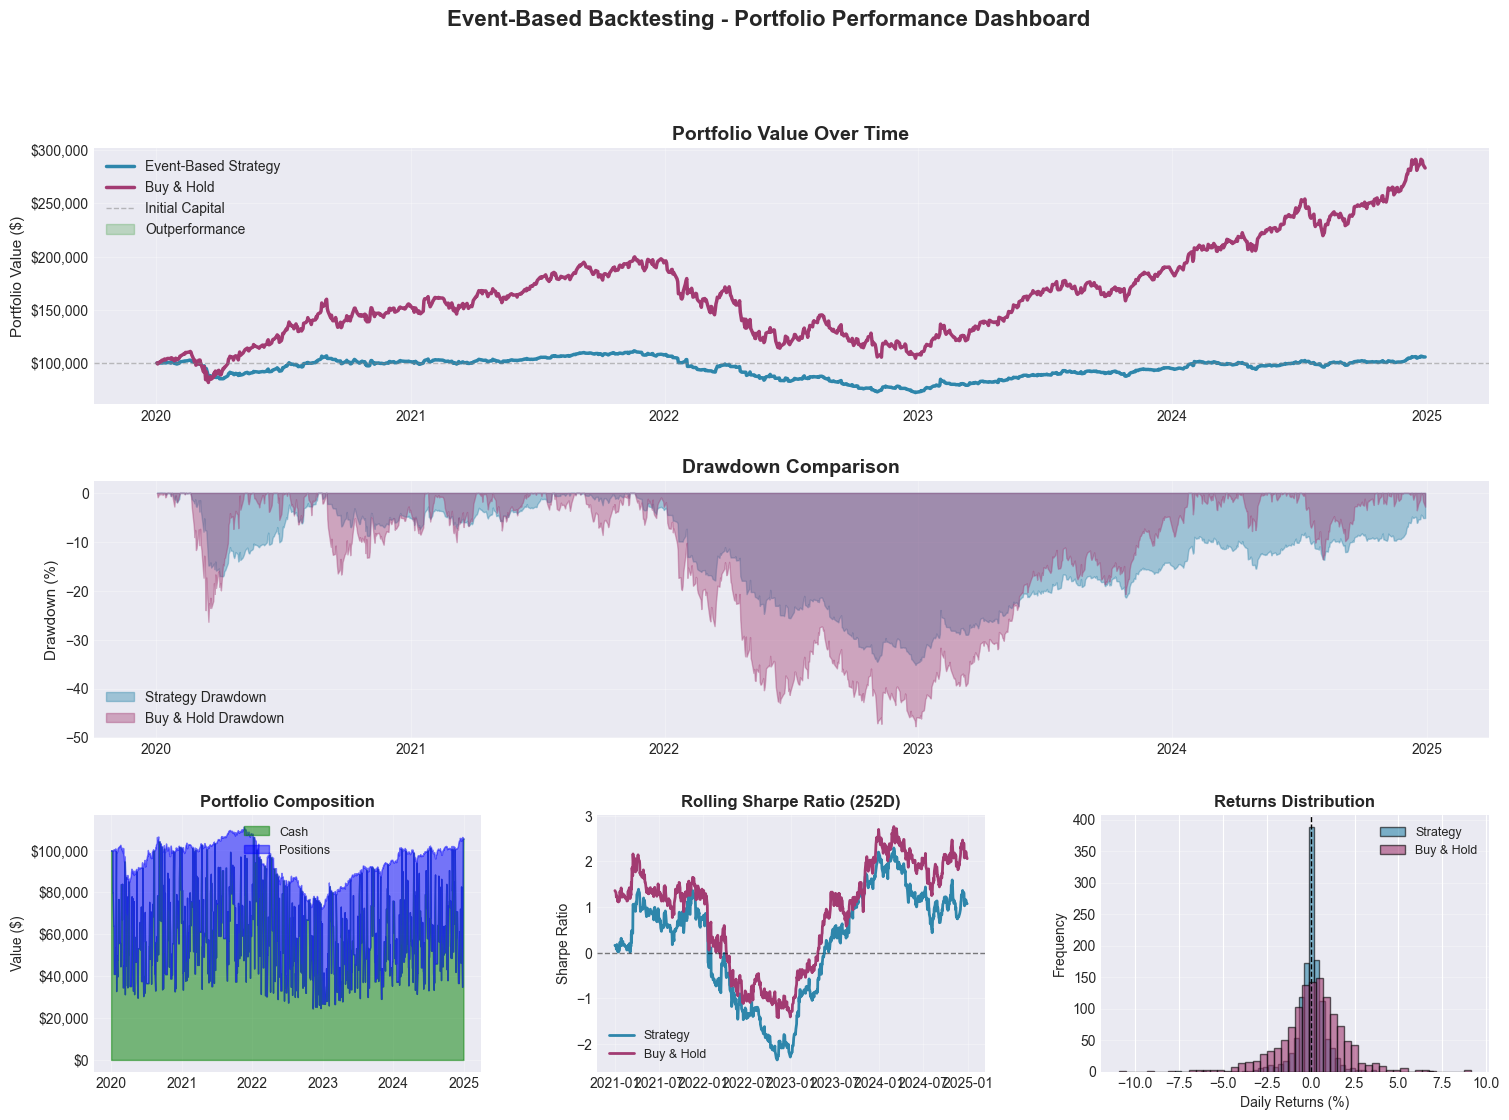

In [43]:
# Plot comprehensive portfolio performance
plot_portfolio_performance(portfolio_df, data_dict, initial_capital)

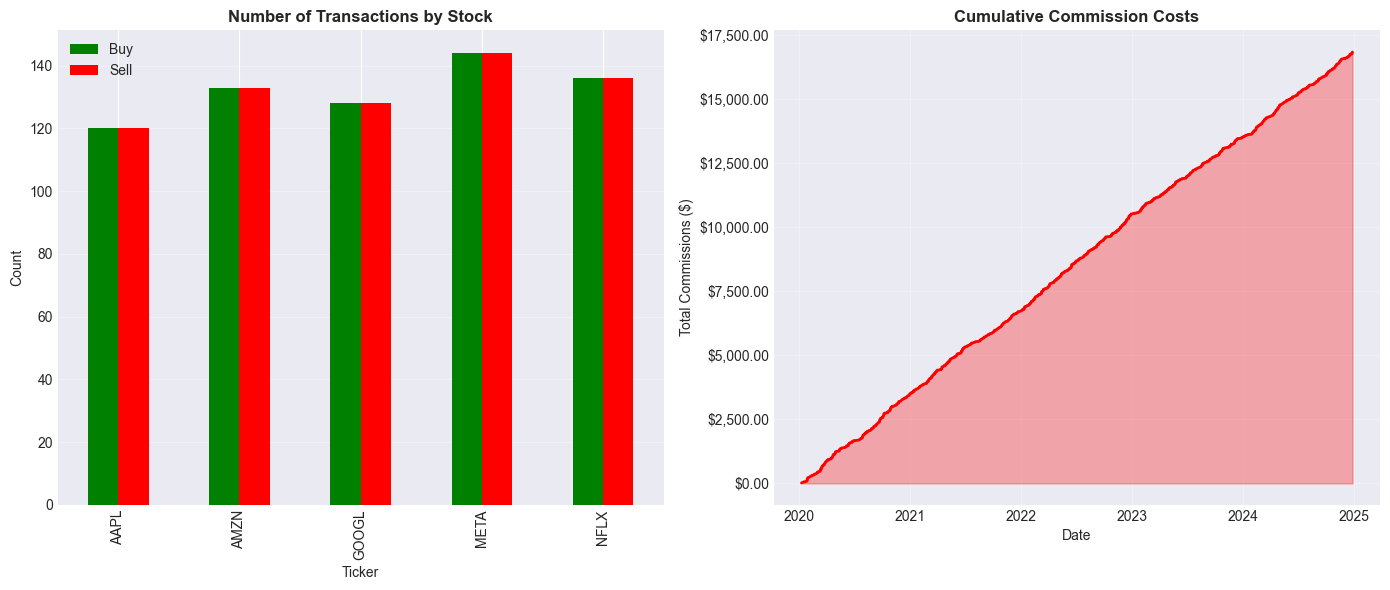

In [44]:
# Plot transaction history
plot_transactions(transactions_df)

## 12. Detailed Transaction Log

In [45]:
print("\nFirst 10 Transactions:")
display(transactions_df.head(10))

print("\nLast 10 Transactions:")
display(transactions_df.tail(10))


First 10 Transactions:


,date,ticker,action,quantity,price,commission,capital
0,2020-01-09,AAPL,BUY,267,74.779755,19.966194,80013.839317
1,2020-01-13,NFLX,BUY,47,338.920013,15.929241,64068.669445
2,2020-01-15,META,BUY,58,219.795029,12.748112,51307.809670
3,2020-01-16,AMZN,BUY,109,93.897003,10.234773,41062.801550
4,2020-01-23,META,SELL,58,218.413544,12.667986,53718.119100
5,2020-01-27,AAPL,SELL,267,74.615532,19.922347,73620.543776
6,2020-01-27,AMZN,SELL,109,91.417000,9.964453,83575.032303
7,2020-01-27,NFLX,SELL,47,342.880005,16.115360,99674.277172
8,2020-01-28,META,BUY,92,216.455612,19.913916,79740.446935
9,2020-01-28,AAPL,BUY,207,76.726357,15.882356,63842.208782



Last 10 Transactions:


,date,ticker,action,quantity,price,commission,capital
1312,2024-12-18,GOOGL,SELL,59,187.787766,11.079478,82828.203900
1313,2024-12-19,AMZN,BUY,74,223.289993,16.523460,66288.220938
1314,2024-12-19,NFLX,BUY,14,902.039978,12.628560,53647.032686
1315,2024-12-23,META,BUY,17,598.452087,10.173685,43463.173514
1316,2024-12-23,GOOGL,BUY,44,193.997543,8.535892,34918.745716
1317,2024-12-26,META,SELL,17,601.943909,10.233046,45141.559117
1318,2024-12-26,AMZN,SELL,74,227.050003,16.801700,61926.457643
1319,2024-12-26,NFLX,SELL,14,924.140015,12.937960,74851.479887
1320,2024-12-27,AAPL,SELL,88,254.685867,22.412356,97241.423854
1321,2024-12-27,GOOGL,SELL,44,192.133606,8.453879,105686.848638
